In [2]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

import configparser
import logging
from functools import partial
from typing import OrderedDict

import numpy as np
from shapely import Polygon

from bbtoolkit.dynamics import DynamicsManager
from bbtoolkit.dynamics.callbacks.attention import AttentionCallback
from bbtoolkit.dynamics.callbacks.fov import EgoCallback, EgoSegmentationCallback, FOVCallback, ParietalWindowCallback
from bbtoolkit.dynamics.callbacks.movement import MovementCallback, MovementSchedulerCallback, TrajectoryCallback
from bbtoolkit.dynamics.callbacks.viz import AgentPlotter, PlottingCallback

from bbtoolkit.models.bb.callbacks import FramesStoringCallback, TimerCallback
from bbtoolkit.models.bb.callbacks.memory import ObjectWeightsUpdatingCallback
from bbtoolkit.models.bb.callbacks.movement import MentalMovementCallback, MentalMovementSchedulerCallback, MentalPositionCallback, MentalTrajectoryCallback
from bbtoolkit.models.bb.callbacks.populations import BVCCallback, GCRateCallback, HDCallback, IPRateCallback, OVCCallback, PCCallback, PRCallback, PWCallback,\
    TCCallback, oPRCallback, oPWCallback, oTCCallback
from bbtoolkit.models.bb.callbacks.viz import AloEnvPlotter, BVCPlotter, DistanceAttentionPlotter, EgoEnvPlotter, HDPlotter, MentalAgentPlotter,\
    MentalTargetPlotter, MentalTrajectoryPlotter, MouseEventCallback, OVCPlotter, ObjectRecallCallback, PCPlotter, PWPlotter, PickedObjectPlotter,\
    TargetPlotter, TimerPlotter, TrajectoryPlotter, oPRPlotter, oPWPlotter
from bbtoolkit.models.bb.structures import BBCache, ClickParameters, DynamicParameters, EcodingParameters
from bbtoolkit.models.bb.utils import Grid2CartTransition, connectivity_config2dict, activity2rate
from bbtoolkit.models.bb.neural_generators import TCGenerator, GCMap

from bbtoolkit.utils.attention import DistanceAttention
from bbtoolkit.utils.movement import MovementManager
from bbtoolkit.utils.movement.trajectory import AStarTrajectory
from bbtoolkit.utils.datautils import Cached
from bbtoolkit.utils.datautils.configparser import EvalConfigParser
from bbtoolkit.utils.math import pol2cart
from bbtoolkit.utils.math.geometry import calculate_polar_distance, points2segments
from bbtoolkit.utils.viz.colors import generate_cmap

from bbtoolkit.environment import Environment
from bbtoolkit.environment.compilers import DynamicEnvironmentCompiler
from bbtoolkit.environment.compilers.callbacks import TransparentObjects
from bbtoolkit.environment.utils import env2builder
from bbtoolkit.environment.visible_planes import LazyVisiblePlaneWithTransparancy
from bbtoolkit.environment.fov import FOVManager
from bbtoolkit.environment.fov.ego import EgoManager

from bbtoolkit.structures.geometry import Texture, TexturedPolygon
from bbtoolkit.structures.tensorgroups import DirectedTensorGroup, dict2directed_tensor, DirectedTensor, TensorGroup, NamedTensor


In [3]:
from bbtoolkit.models.bb.neural_generators import MTLGenerator


env = environment = Environment.load('../data/envs/square_environment.pkl')
mtl_cfg = '../cfg/cells/mtl_cells.ini'
config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
config.read(mtl_cfg)

space_section = config['Space']
res = space_section.eval('res')
r_max = space_section.eval('r_max')

polargrid_section = config['PolarGrid']
polar_dist_res = polargrid_section.eval('polar_dist_res')
polar_ang_res = polargrid_section.eval('polar_ang_res', locals=dict(pi=np.pi))
h_sig = polargrid_section.eval('sigma_hill')


gen = MTLGenerator(
    r_max, h_sig, polar_dist_res, polar_ang_res, env
)

coords, n_h_neurons_total, n_neurons = gen.get_coords()
n_bvc, bvc_dist, bvc_ang = gen.get_bvc_params()

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from collections import namedtuple

# Assuming Sample is defined as:
Sample = namedtuple('Sample', 'coords bvc pc')



In [27]:
from bbtoolkit.models.bb.neural_generators import get_boundary_activations
from bbtoolkit.structures.geometry import Coordinates2D


samples = list()

for location in range(environment.walls[0].visible_parts.shape[0]):
    pos_x = environment.params.coords[location, 0]
    pos_y = environment.params.coords[location, 1]
    all_visible_parts_x, all_visible_parts_y, all_non_nan_indices, all_boundary_point_texture = list(), list(), list(), list()
    for wall in environment.walls:
        visible_parts_x = wall.visible_parts[location, :, 0]
        visible_parts_y = wall.visible_parts[location, :, 1]
        non_nan_indices = np.where(~np.isnan(visible_parts_x))[0]
        boundary_point_texture = wall.polygon.texture.id_*np.ones_like(non_nan_indices)
        all_visible_parts_x.append(visible_parts_x[non_nan_indices])
        all_visible_parts_y.append(visible_parts_y[non_nan_indices])
        all_non_nan_indices.append(non_nan_indices)
        all_boundary_point_texture.append(boundary_point_texture)

    visible_parts_x = np.concatenate(all_visible_parts_x)
    visible_parts_y = np.concatenate(all_visible_parts_y)
    visible_boundary_points = Coordinates2D(
        visible_parts_x - pos_x,
        visible_parts_y - pos_y
    )
    non_nan_indices = np.concatenate(all_non_nan_indices)
    boundary_point_texture = np.concatenate(all_boundary_point_texture)

    boundary_theta, boundary_r = np.arctan2(visible_boundary_points.y, visible_boundary_points.x), np.sqrt(visible_boundary_points.x**2 + visible_boundary_points.y**2)
    boundary_r[boundary_r < gen.polar_dist_res] = gen.polar_dist_res

    h_activarions = np.exp(-((coords.x.reshape((-1, 1)) - pos_x)**2 + (coords.y.reshape((-1, 1)) - pos_y)**2) / (.75**2))
    bvc_activations = np.zeros(n_bvc)

    for boundary_point in range(visible_boundary_points.x.size):
        delayed_bvc_activations = get_boundary_activations(
            bvc_ang,
            boundary_theta[boundary_point],
            bvc_dist,
            boundary_r[boundary_point],
            sigma_r0=gen.sigma_r0,
            sigma_th=gen.sigma_th,
            mask=bvc_activations <= 1
        )
        bvc_activations += delayed_bvc_activations

    samples.append(Sample((pos_x, pos_y), bvc_activations, h_activarions))

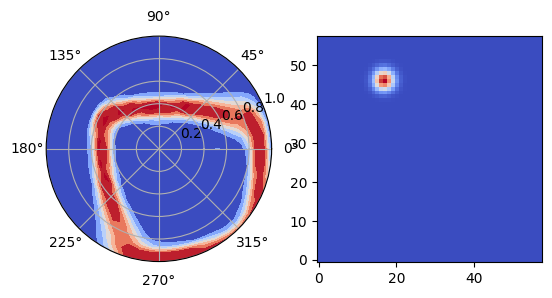

In [28]:
from matplotlib import pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='polar')
theta_bvc, r_bvc = np.meshgrid(
    np.linspace(0, 2 * np.pi, 51),  # Angular dimension
    np.linspace(0, 1, 16)  # Radial dimension, adjust as necessary
)

ax.contourf(
    theta_bvc.T,
    r_bvc.T,
    np.reshape(samples[1050].bvc, (51, 16)),
    cmap='coolwarm',
    vmin=0, vmax=1,
    extend="both"
)


ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(np.reshape(samples[1050].pc, (58, 58)), origin='lower', cmap='coolwarm')

In [23]:
np.sqrt(len(samples[1050].pc))

58.0

In [ ]:
samples[0].bvc

In [29]:
# Define a custom dataset
class GridDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        # Convert bvc and pc to tensors
        bvc_tensor = torch.FloatTensor(sample.bvc)
        pc_tensor = torch.FloatTensor(sample.pc)
        return bvc_tensor, pc_tensor

# Create the dataset
dataset = GridDataset(samples)

# Shuffle and split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Now you can use train_loader and test_loader for training and testing your model

In [38]:
import torch.nn as nn

class GridNet(nn.Module):
    def __init__(self, m, n, p, activation=None):
        super().__init__()
        self.layer1 = nn.Linear(m, n)
        self.layer2 = nn.Linear(n, p)

        # Select the activation function
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif isinstance(activation, nn.Module):
            self.activation = activation
        elif activation is None:
            self.activation = nn.Identity()
        else:
            raise ValueError(f'Unsupported activation function: {activation}')

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.activation(x)
        return x

In [39]:
import torch
import torch.nn as nn
import numpy as np

class DynamicWeightedMSELoss(nn.Module):
    def __init__(self, sigma=10.0):
        """
        Initializes the dynamic weighted MSE loss.
        :param sigma: The standard deviation of the Gaussian weight distribution.
        """
        super(DynamicWeightedMSELoss, self).__init__()
        self.sigma = sigma

    def forward(self, prediction, target):
        """
        Computes the dynamic weighted MSE loss.
        :param prediction: The predicted output (flattened).
        :param target: The target output (flattened).
        """
        # Reshape prediction and target to 2D (assuming 58x58 as mentioned)
        pred = prediction.view(-1, 58, 58)
        targ = target.view(-1, 58, 58)

        # batch_size, height, width = targ.shape
        # targ_flat = targ.view(batch_size, -1)
        # _, indices = targ_flat.max(1)  # Find the index of the max value in the flattened target
        # centers_y = indices // width
        # centers_x = indices % width

        # # Create a meshgrid of coordinates (x, y) for each pixel
        # x = torch.arange(0, width, device=pred.device).repeat(height, 1)
        # y = torch.arange(0, height, device=pred.device).repeat(1, width)

        # # Compute weights for each example in the batch
        # weights = torch.zeros_like(pred)
        # for i in range(batch_size):
        #     center_x = centers_x[i].float()
        #     center_y = centers_y[i].float()
        #     dist_sq = (x - center_x)**2 + (y - center_y)**2
        #     weights[i] = torch.exp(-dist_sq / (2 * self.sigma**2))

        # # Normalize weights to have a maximum of 1
        # weights = weights / weights.view(batch_size, -1).max(1)[0].view(-1, 1, 1)

        # Compute weighted MSE
        diff = pred - targ
        # weighted_diff = diff * weights
        # loss = (weighted_diff**2).mean()
        loss = (diff**2).sum()

        return loss

# Example usage
prediction = torch.randn(10, 3364)  # Example prediction
target = torch.randn(10, 3364)  # Example target, with the peak at different positions
loss_fn = DynamicWeightedMSELoss(sigma=10)  # Initialize with a chosen sigma
loss = loss_fn(prediction, target)
print(loss)

tensor(66439.6406)


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming your model is already defined and instantiated
model = GridNet(816, 700, 3364)

# Define the loss function and optimizer
criterion = DynamicWeightedMSELoss()  # Assuming RMSLELoss is defined elsewhere
optimizer = optim.Adam(model.parameters())

# Specify the number of epochs and the L2 regularization strength
num_epochs = 100
l2_lambda = 0.001  # L2 regularization strength

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Move data to the appropriate device
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Manually add L2 regularization for layer1
        l2_penalty = None
        for param in model.layer1.parameters():
            if l2_penalty is None:
                l2_penalty = param.norm(2)
            else:
                l2_penalty = l2_penalty + param.norm(2)
        l2_penalty = l2_lambda * l2_penalty

        # Combine the original loss with the L2 penalty
        loss = loss + l2_penalty

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # Optional: Evaluate the model on the test set after each epoch
    # (Evaluation code remains unchanged)

print('Training complete')

Epoch 1/100, Loss: 877.2017
Epoch 2/100, Loss: 408.9224
Epoch 3/100, Loss: 349.6647
Epoch 4/100, Loss: 321.3730
Epoch 5/100, Loss: 302.0996
Epoch 6/100, Loss: 291.0817
Epoch 7/100, Loss: 280.3448
Epoch 8/100, Loss: 272.5784
Epoch 9/100, Loss: 265.6357
Epoch 10/100, Loss: 261.4480
Epoch 11/100, Loss: 260.5836
Epoch 12/100, Loss: 252.7278
Epoch 13/100, Loss: 245.1014
Epoch 14/100, Loss: 240.1071
Epoch 15/100, Loss: 235.3637
Epoch 16/100, Loss: 231.7643
Epoch 17/100, Loss: 228.9658
Epoch 18/100, Loss: 222.5160
Epoch 19/100, Loss: 222.8876
Epoch 20/100, Loss: 222.7786
Epoch 21/100, Loss: 214.4561
Epoch 22/100, Loss: 212.8211
Epoch 23/100, Loss: 215.0565
Epoch 24/100, Loss: 215.1172
Epoch 25/100, Loss: 207.3644
Epoch 26/100, Loss: 206.1185
Epoch 27/100, Loss: 203.1456
Epoch 28/100, Loss: 201.9062
Epoch 29/100, Loss: 199.6125
Epoch 30/100, Loss: 198.2137
Epoch 31/100, Loss: 197.2855
Epoch 32/100, Loss: 194.8785
Epoch 33/100, Loss: 194.3060
Epoch 34/100, Loss: 193.3799
Epoch 35/100, Loss: 192

In [47]:
with torch.no_grad():
    model.eval()
    x, y = next(iter(test_loader))
    pred = model(x)


In [58]:
x.shape, pred.shape

(torch.Size([64, 816]), torch.Size([64, 3364]))

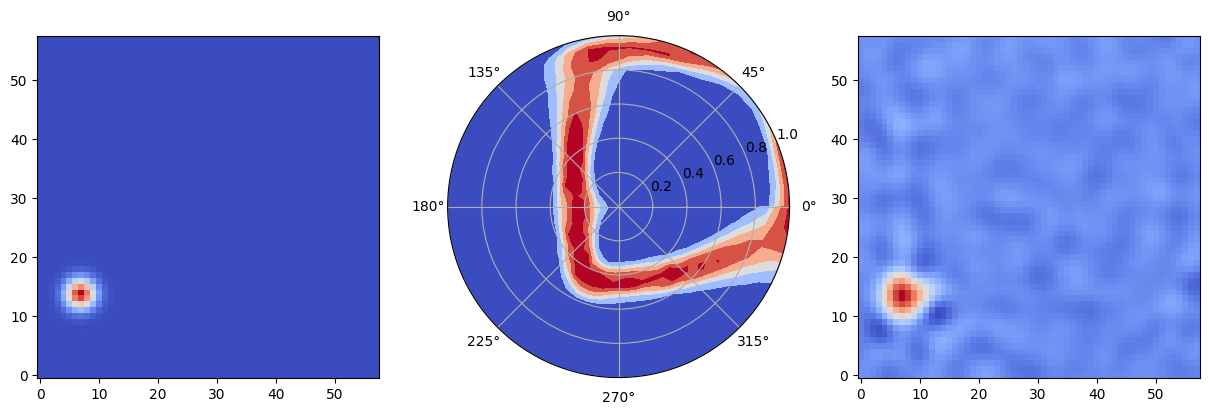

In [61]:
from matplotlib import pyplot as plt


theta_bvc, r_bvc = np.meshgrid(
    np.linspace(0, 2 * np.pi, 51),  # Angular dimension
    np.linspace(0, 1, 16)  # Radial dimension, adjust as necessary
)


# ax2 = fig.add_subplot(1, 2, 2)
# ax2.imshow(np.reshape(samples[1050].pc, (58, 58)), origin='lower', cmap='coolwarm')


fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2, projection='polar')
ax3 = fig.add_subplot(1, 3, 3)

ax1.imshow(np.reshape(y[0], (58, 58)), origin='lower', cmap='coolwarm')

ax2.contourf(
    theta_bvc.T,
    r_bvc.T,
    np.reshape(x[0], (51, 16)),
    cmap='coolwarm',
    vmin=0, vmax=1,
    extend="both"
)

ax3.imshow(np.reshape(pred[0], (58, 58)), origin='lower', cmap='coolwarm')


In [65]:
all_bvcs = list()
for sample in samples:
    all_bvcs.append(torch.tensor(sample.bvc))

In [66]:
torch.stack(all_bvcs).shape

torch.Size([3481, 816])

In [71]:
all_bvcs = list()
for sample in dataset:
    all_bvcs.append(sample[0])

In [72]:
torch.stack(all_bvcs).shape

torch.Size([3481, 816])

In [74]:
with torch.no_grad():
    model.eval()
    # x, y = next(iter(test_loader))
    bvc2gc = model.layer1(torch.stack(all_bvcs)).detach().numpy()
    print(bvc2gc.shape)

(3481, 700)


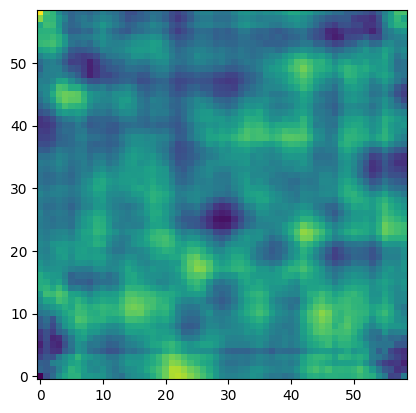

In [87]:
plt.imshow(np.reshape(bvc2gc[:, 8], (59, 59)), origin='lower')